# Are they good compared to hMOF? 
We have computed the properties for some entries in hMOF that have similar structures to those we generate with MOFA. 
Here, we assess how the properties between the two sets compare

In [ ]:
import pandas as pd
import seaborn as sns
import typing as t

from matplotlib import pyplot as plt
from pathlib import Path

FIGS_DIR: t.Final[Path] = Path("figures")
SUMMARIES_DIR: t.Final[Path] = Path("../summaries/450-nodes.csv.gz")
SUPPL_DIR: t.Final[Path] = Path("suppl_data")

FIGS_DIR.mkdir(exist_ok=True)

## Pull the Summaries of Each Dataset
Load the hMOF and MOFA summaries

### Load hMOF Ad Hoc Data
We ran a small, randomly-selected population of MOFs from hMOF. Their data are stored in multiple files

In [3]:
hmof_strain = (
    pd.read_json(SUPPL_DIR / "uff-strains.jsonl", lines=True)
    .query("timesteps == 1e6")
    .drop_duplicates("mof")
)
print(f"The number of hMOF structures: {len(hmof_strain)}.")
hmof_strain.head()

The number of hMOF structures: 121.


,host,lammps_cmd,timesteps,mof,runtime,strain
0,bettik-linux,[/home/lward/Software/lammps-2Aug2023/build/lm...,1000000,mof-c05f4470,1209.371764,1.357353
1,bettik-linux,[/home/lward/Software/lammps-2Aug2023/build/lm...,1000000,mof-1305ad29,1729.896483,2.118927
2,bettik-linux,[/home/lward/Software/lammps-2Aug2023/build/lm...,1000000,mof-9bae2bbe,1168.651650,0.263745
3,bettik-linux,[/home/lward/Software/lammps-2Aug2023/build/lm...,1000000,mof-775518a7,1410.288954,0.482247
4,bettik-linux,[/home/lward/Software/lammps-2Aug2023/build/lm...,1000000,mof-b9c71836,1347.897951,0.471681


In [4]:
hmof_capac = (
    pd.read_json(SUPPL_DIR / "uff-capacity.jsonl", lines=True)
    .query("opt_steps == 8")
    .drop_duplicates("mof")
)
print(f"The number of hMOF structures: {len(hmof_capac)}.")
hmof_capac.head()

The number of hMOF structures: 92.


,mof,opt_steps,runtime,mean,std
0,mof-775518a7,8,5702.68282,0.980114,0.016130
1,mof-a2171adf,8,NaN,0.103095,0.000970
2,mof-c05f4470,8,NaN,0.060511,0.000669
3,mof-86533c22,8,NaN,0.103757,0.000994
4,mof-2a768a8f,8,NaN,0.121500,0.002563


In [5]:
hmof_data = pd.merge(
    hmof_strain[["mof", "strain"]],
    hmof_capac[["mof", "mean"]].rename(columns={"mean": "capacity"}),
    how="inner",
    on="mof",
)
print(f"Found {len(hmof_data)} MOFs from hMOF with both properties")
hmof_data.describe()

Found 69 MOFs from hMOF with both properties


,strain,capacity
count,69.000000,69.000000
mean,0.811525,0.199516
std,0.436531,0.405736
min,0.263745,0.043484
25%,0.464835,0.072787
50%,0.743941,0.104941
75%,0.906546,0.160450
max,2.118927,3.228475


### Load MOFA Data
It's all in a huge CSV. Let's query down to only those with a capacity measurement

In [6]:
mofa_data = pd.read_csv(SUMMARIES_DIR)
mofa_data = mofa_data[~mofa_data["gas_storage.CO2"].isnull()]
print(f"Found {len(mofa_data)} MOFA MOFs with both properties")
mofa_data[["gas_storage.CO2", "structure_stability.uff"]].describe()

Found 224 MOFA MOFs with both properties


,gas_storage.CO2,structure_stability.uff
count,224.000000,224.000000
mean,0.229604,0.098604
std,0.376915,0.171745
min,0.069247,0.016368
25%,0.081330,0.040997
50%,0.091433,0.047582
75%,0.174217,0.052707
max,4.047024,1.870881


## Make a Pareto Plot
Show the MOFA MOFs as small dots in the background so we can highlight the hMOF ones in the foreground

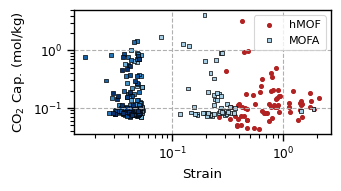

In [7]:
with sns.plotting_context("paper", font_scale=1.0):
    fig, ax = plt.subplots(figsize=(3.5, 2.0))

    ax.grid(linestyle="--")
    ax.scatter(
        hmof_data["strain"], hmof_data["capacity"], color="firebrick", label="hMOF", s=8
    )
    ax.scatter(
        mofa_data["structure_stability.uff"],
        mofa_data["gas_storage.CO2"],
        label="MOFA",
        s=8,
        cmap="Blues",
        c=mofa_data["walltime"] / 3600,
        vmin=-0.8,
        vmax=1.5,
        marker="s",
        edgecolor="k",
        linewidth=0.5,
    )

    ax.set_yscale("log")
    ax.set_xscale("log")

    ax.set_ylabel("CO$_2$ Cap. (mol/kg)")
    ax.set_xlabel("Strain")

    ax.legend(fontsize=8)

    fig.tight_layout()
    fig.savefig(FIGS_DIR / "fig8.pdf", bbox_inches="tight")
    plt.show()